## Importing libraries required for data loading, visualization , pre-processing, training and testing

In [11]:
# Load the FashionMNIST dataset
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
import random

import pickle
import gzip
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

## Selecting device to run experiments (GPU/CPU)

In [2]:
#Setting random seed
random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if gpu is available then "cuda:0" else "cpu"
print(device)

cpu


## Downloading dataset from torchvision and saving as csv to compare with ML models

In [3]:
train_csv_file = "./data/FashionMNIST/fashion-mnist_train.csv"
test_csv_file = "./data/FashionMNIST/fashion-mnist_test.csv"

train_csv_exists = os.path.exists(train_csv_file)
test_csv_exists = os.path.exists(test_csv_file)

if train_csv_exists == False or test_csv_exists == False:

    # Download train and test dataset from torchvision
    train_dataset_ori = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
    test_dataset_ori = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

    # Transform pixels and target into numpy array
    train_data = train_dataset_ori.data.view(-1, 28 * 28).numpy()
    train_targets = train_dataset_ori.targets.numpy()

    test_data = test_dataset_ori.data.view(-1, 28 * 28).numpy()
    test_targets = test_dataset_ori.targets.numpy()

    # Create a pandas data frame and save it as csv file
    df_train = pd.DataFrame(data=train_data, columns=[f"pixel_{i}" for i in range(28 * 28)])
    df_train["label"] = train_targets
    df_train.to_csv("./data/FashionMNIST/fashion-mnist_train.csv", index=False)

    df_test = pd.DataFrame(data=test_data, columns=[f"pixel_{i}" for i in range(28 * 28)])
    df_test["label"] = test_targets
    df_test.to_csv("./data/FashionMNIST/fashion-mnist_test.csv", index=False)

else:
    df_train = pd.read_csv(train_csv_file)
    df_test = pd.read_csv(test_csv_file)

100%|██████████| 26421880/26421880 [00:02<00:00, 10349797.35it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208566.90it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3915844.47it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12430786.98it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Custom torch datatset FMNIST_Datatset to load images from csv file.

In [4]:
class FMNIST_Dataset(Dataset):
    """Creating a subclass of PyTorch dataset to load images from CSV files."""

    def __init__(self, csv_file, transform = None):
        """
        Arguments:
            csv_file (string): Path to the csv file with image labels and pixels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):

        label = self.data_frame.iloc[idx, -1]
        image = self.data_frame.iloc[idx, :-1].values

        image = image.reshape(28, 28, 1).astype('float32')
        #image = image/255.0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

### Dataset to be used for DL models

In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = FMNIST_Dataset("./data/FashionMNIST/fashion-mnist_train.csv", transform=train_transforms)
test_dataset = FMNIST_Dataset("./data/FashionMNIST/fashion-mnist_test.csv", transform=test_transforms)

## Dividing flatten images and labels to be used by ML models

In [ ]:
# Split flatten image and labels

train_images_flat = df_train.drop(['label'], axis=1)
train_labels = df_train['label'].values

test_images_flat = df_test.drop(['label'], axis=1)
test_labels = df_test['label'].values

## Data Cleaning
### Check for missing values

In [ ]:
print("Missing values in training data:", df_train.isnull().sum().sum())
print("Missing values in testing data:", df_test.isnull().sum().sum())

Missing values in training data: 0
Missing values in testing data: 0


## Data transformation
### Standard scaler is used to normalize data with mean=0 and std_dev=1

In [ ]:
# Standardize the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images_flat)
test_images_scaled = scaler.transform(test_images_flat)

## EDA
### Class-distribution
It is said that all classes are uniformly distributed

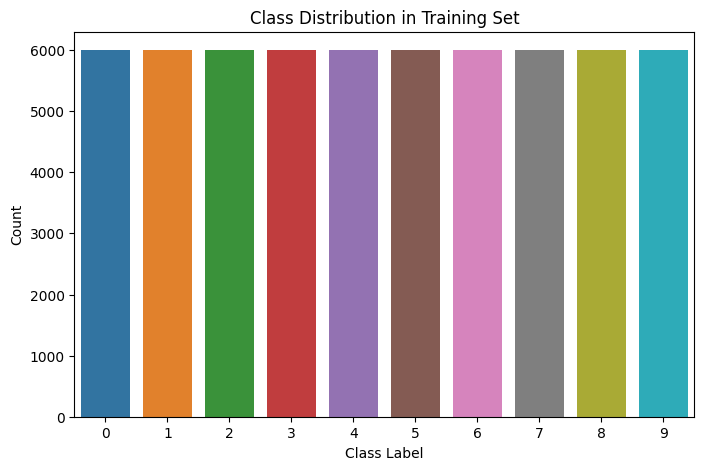

In [ ]:
# Display class distribution in the training set
plt.figure(figsize=(8, 5))
sns.countplot(df_train, x='label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

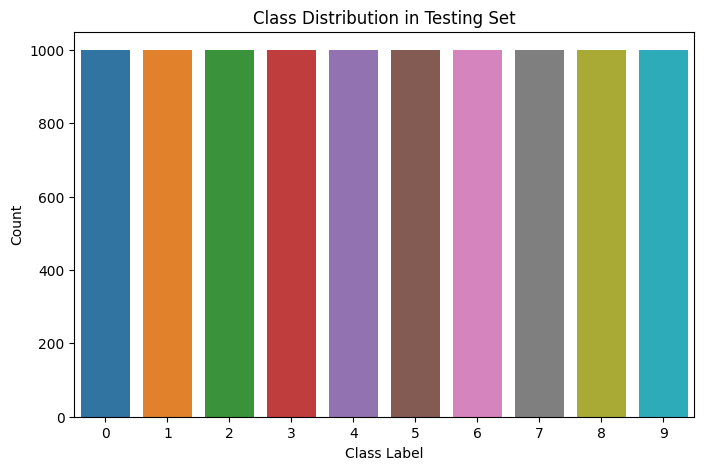

In [ ]:
# Display class distribution in the testing set
plt.figure(figsize=(8, 5))
sns.countplot(df_test, x='label')
plt.title('Class Distribution in Testing Set')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

### Label mapping from index to class names

In [12]:
labels_map_dict = {0 : 'T-Shirt',
                   1 : 'Trouser',
                   2 : 'Pullover',
                   3 : 'Dress',
                   4 : 'Coat',
                   5 : 'Sandal',
                   6 : 'Shirt',
                   7 : 'Sneaker',
                   8 : 'Bag',
                   9 : 'Ankle Boot'}

### Visualizing some samples from the datatset.

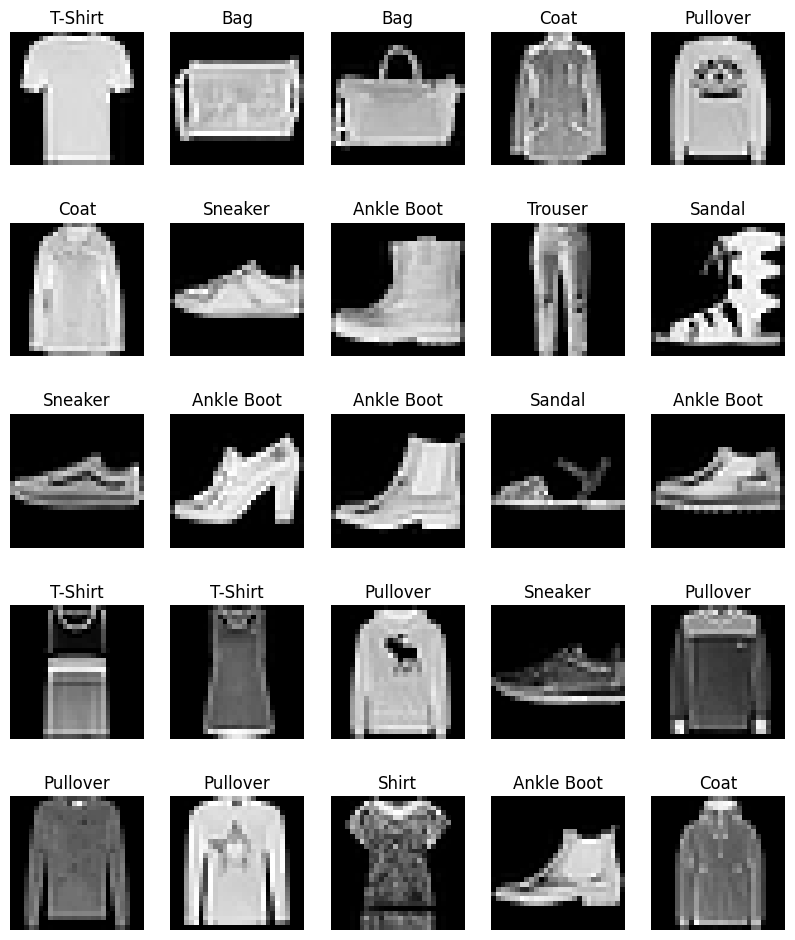

In [ ]:
fig = plt.figure(figsize=(10,12))

cols = 5
rows = 5

for i in range(1, cols*rows +1):
    index = np.random.randint(len(train_labels))
    img = train_images_flat.iloc[index].values.reshape(28,28)
    lab = labels_map_dict[train_labels[index]]

    fig.add_subplot(rows, cols, i)
    plt.title(lab)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show();

### Dimension reduction using PCA
784 features is reduced to 50 PCA components

In [ ]:
# Apply PCA

from sklearn.decomposition import PCA

n = 50
pca = PCA(n_components = n)
train_images_pca = pca.fit_transform(train_images_scaled)
test_images_pca = pca.transform(test_images_scaled)

In [ ]:
print("Variance captured using 50 components: {:.3f}%".format(pca.explained_variance_ratio_.sum()*100))

Variance captured using 50 components: 80.062%


### tsne plot for PCA components

In [ ]:
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(train_images_pca)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.015s...
[t-SNE] Computed neighbors for 60000 samples in 38.636s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

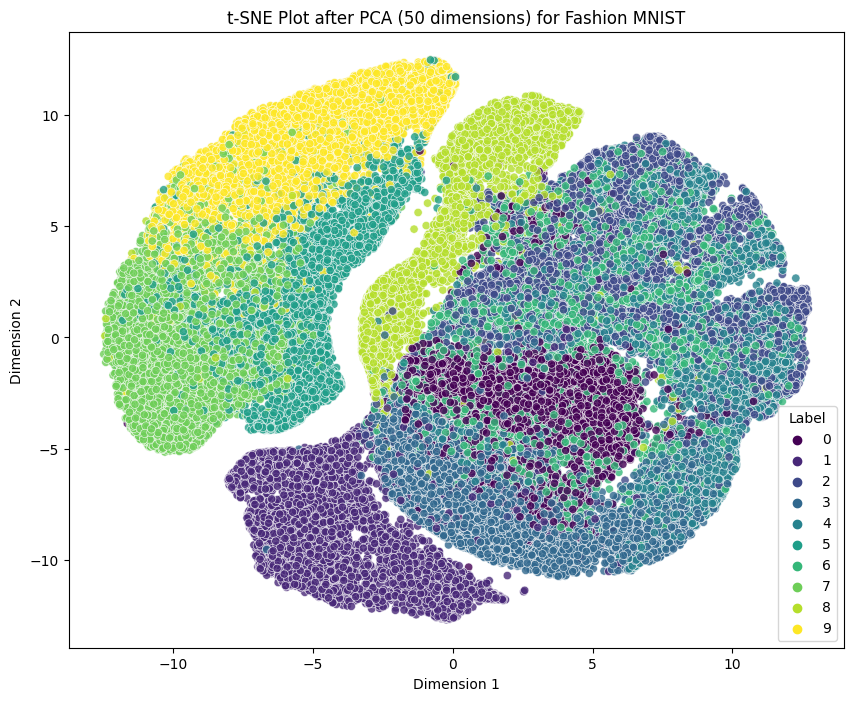

In [ ]:
# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_pca_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Label'] = train_labels

# Plot the t-SNE plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, legend='full', palette='viridis', alpha=0.8)
plt.title('t-SNE Plot after PCA (50 dimensions) for Fashion MNIST')
plt.show();

## ML models- training and testing

### KNN

In [ ]:
# KNN Cross Validation PCA
knn = KNeighborsClassifier(n_neighbors=5)

cross_val_scores_pca_knn = cross_val_score(knn, train_images_pca, train_labels, cv=3, scoring='accuracy', verbose = 2)

print("Cross-Validation Scores on PCA-converted data:", cross_val_scores_pca_knn)
print("Average Accuracy on PCA-converted data:", np.mean(cross_val_scores_pca_knn))

[CV] END .................................................... total time=   8.8s
[CV] END .................................................... total time=   7.0s
[CV] END .................................................... total time=   8.6s
Cross-Validation Scores on PCA-converted data: [0.84985 0.8525  0.84985]
Average Accuracy on PCA-converted data: 0.8507333333333333


In [ ]:
knn.fit(train_images_pca, train_labels)
y_test_pred = knn.predict(test_images_pca)

accuracy_test = accuracy_score(test_labels, y_test_pred)
print(f"Accuracy on test set: {accuracy_test * 100:.2f}%")

Accuracy on test set: 85.12%


### Logistic Regression

In [ ]:
# Logistic Regression Cross Validation PCA

logreg = LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)

cross_val_scores_pca_logreg = cross_val_score(logreg, train_images_pca, train_labels, cv=3, scoring='accuracy', verbose = 2)

print("Cross-Validation Scores on PCA-converted data:", cross_val_scores_pca_logreg)
print("Average Accuracy on PCA-converted data:", np.mean(cross_val_scores_pca_logreg))

[CV] END .................................................... total time=  20.2s
[CV] END .................................................... total time=  20.9s
[CV] END .................................................... total time=  21.1s
Cross-Validation Scores on PCA-converted data: [0.83045 0.8284  0.82585]
Average Accuracy on PCA-converted data: 0.8282333333333334


In [ ]:
# Apply Logistic Regression on the PCA-converted dataset
logreg.fit(train_images_pca, train_labels)
y_pred_pca = logreg.predict(test_images_pca)

accuracy_pca = accuracy_score(test_labels, y_pred_pca)
print(f"Accuracy on PCA-converted dataset: {accuracy_pca * 100:.2f}%")

Accuracy on PCA-converted dataset: 81.57%


### Gradient Boosting

In [ ]:
# Gradient Boosting Cross Validation PCA

gb = GradientBoostingClassifier(random_state=42)

cross_val_scores_pca_gb = cross_val_score(gb, train_images_pca, train_labels, cv=3, scoring='accuracy', verbose = 2)

print("Cross-Validation Scores on PCA-converted data:", cross_val_scores_pca_gb)
print("Average Accuracy on PCA-converted data:", np.mean(cross_val_scores_pca_gb))

[CV] END .................................................... total time=19.4min
[CV] END .................................................... total time=21.4min
[CV] END .................................................... total time=22.0min
Cross-Validation Scores on PCA-converted data: [0.8428  0.84745 0.8411 ]
Average Accuracy on PCA-converted data: 0.8437833333333332


In [ ]:
# Apply Gradient Boosting on the PCA-converted dataset

gb.fit(train_images_pca, train_labels)
y_pred_pca = gb.predict(test_images_pca)

accuracy_pca = accuracy_score(test_labels, y_pred_pca)
print(f"Accuracy on PCA-converted dataset: {accuracy_pca * 100:.2f}%")

Accuracy on PCA-converted dataset: 83.55%


### SVC

In [ ]:
# SVC Cross Validation PCA

svc = SVC(random_state=42)

cross_val_scores_pca_svc = cross_val_score(svc, train_images_pca, train_labels, cv=3, scoring='accuracy', verbose = 2)

print("Cross-Validation Scores on PCA-converted data:", cross_val_scores_pca_svc)
print("Average Accuracy on PCA-converted data:", np.mean(cross_val_scores_pca_svc))

[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time=  53.5s
[CV] END .................................................... total time=  53.7s
Cross-Validation Scores on PCA-converted data: [0.87235 0.87445 0.87205]
Average Accuracy on PCA-converted data: 0.87295


In [ ]:
# Apply Support Vector Classifier on the PCA-converted dataset

svc.fit(train_images_pca, train_labels)
y_pred_pca = svc.predict(test_images_pca)

accuracy_pca = accuracy_score(test_labels, y_pred_pca)
print(f"Accuracy on PCA-converted dataset: {accuracy_pca * 100:.2f}%")

Accuracy on PCA-converted dataset: 86.68%


### Random Forest

In [ ]:
#Random Forest Classifier

rf_classifier = RandomForestClassifier(random_state=42)
cross_val_scores_pca_rf = cross_val_score(rf_classifier, train_images_pca, train_labels, cv=3, scoring='accuracy', verbose = 2)

print("Cross-Validation Scores on PCA-converted data:", cross_val_scores_pca_rf)
print("Average Accuracy on PCA-converted data:", np.mean(cross_val_scores_pca_rf))

[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time=  47.7s
[CV] END .................................................... total time= 1.1min
Cross-Validation Scores on PCA-converted data: [0.8637  0.866   0.85955]
Average Accuracy on PCA-converted data: 0.8630833333333333


In [ ]:
rf_classifier.fit(train_images_pca, train_labels)
y_pred_pca = rf_classifier.predict(test_images_pca)

accuracy_pca = accuracy_score(test_labels, y_pred_pca)
print(f"Accuracy on PCA-converted dataset: {accuracy_pca * 100:.2f}%")

Accuracy on PCA-converted dataset: 85.73%


### Decision Tree

In [ ]:
#Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
cross_val_scores_pca_dt = cross_val_score(dt_classifier, train_images_pca, train_labels, cv=3, scoring='accuracy', verbose = 2)

print("Cross-Validation Scores on PCA-converted data:", cross_val_scores_pca_dt)
print("Average Accuracy on PCA-converted data:", np.mean(cross_val_scores_pca_dt))

[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   9.1s
[CV] END .................................................... total time=   7.7s
Cross-Validation Scores on PCA-converted data: [0.7664  0.77295 0.76715]
Average Accuracy on PCA-converted data: 0.7688333333333333


In [ ]:
dt_classifier.fit(train_images_pca, train_labels)
y_pred_pca = dt_classifier.predict(test_images_pca)

accuracy_pca = accuracy_score(test_labels, y_pred_pca)
print(f"Accuracy on PCA-converted dataset: {accuracy_pca * 100:.2f}%")

Accuracy on PCA-converted dataset: 76.50%


### Linear SVM

In [ ]:
#Linear SVM

svm_classifier = SVC(kernel='linear', random_state=42)
cross_val_scores_pca_svm = cross_val_score(svm_classifier, train_images_pca, train_labels, cv=3, scoring='accuracy', verbose = 2)

print("Cross-Validation Scores on PCA-converted data:", cross_val_scores_pca_svm)
print("Average Accuracy on PCA-converted data:", np.mean(cross_val_scores_pca_svm))

[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 3.0min
Cross-Validation Scores on PCA-converted data: [0.8463 0.8492 0.8443]
Average Accuracy on PCA-converted data: 0.8466


In [ ]:
svm_classifier.fit(train_images_pca, train_labels)
y_pred_pca = svm_classifier.predict(test_images_pca)

accuracy_pca = accuracy_score(test_labels, y_pred_pca)
print(f"Accuracy on PCA-converted dataset: {accuracy_pca * 100:.2f}%")

Accuracy on PCA-converted dataset: 83.62%


## DL-models training and testing
### Defining params class

In [6]:
class Params:
    def __init__(self, loss_fn, lr, momentum, optimizer, k_folds, epochs, batch_size, patience, device):
        self.criterion = loss_fn
        self.learning_rate = lr
        self.momentum = momentum
        self.optimizer = optimizer
        self.k_folds = k_folds
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.device = device

### Resetting models weights before training

In [7]:
def reset_weights(m):
  '''
    Function to reset the model weights in order to avoid weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

### Training and validation function

In [ ]:
def train_val_step(model, train_dataset, model_params):

    results = {}
    train_loss = {}
    valid_loss =  {}
    train_accuracy = {}
    valid_accuracy = {}

    kfold = KFold(n_splits=model_params.k_folds, shuffle=True, random_state=42)

    for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):

        print('FOLD {}'.format(fold))

        train_subsampler = SubsetRandomSampler(train_ids)
        valid_subsampler = SubsetRandomSampler(test_ids)


        train_loader = DataLoader(train_dataset, batch_size=model_params.batch_size, sampler=train_subsampler)
        valid_loader = DataLoader(train_dataset, batch_size=model_params.batch_size, sampler=valid_subsampler)


        device = model_params.device
        epochs = model_params.epochs
        criterion = model_params.criterion
        model.to(device)
        model.train()
        model.apply(reset_weights)

        best_loss = 10000
        patience = model_params.patience

        optimizer = model_params.optimizer

        train_loss[fold] = []
        valid_loss[fold] = []
        train_accuracy[fold] = []
        valid_accuracy[fold] = []

        for epoch in range(0, epochs):

            print('----------Epoch {}----------'.format(epoch+1))
            train_loss_fold = 0
            correct, total = 0, 0

            for i, (image, label) in enumerate(train_loader, 0):

                image, label = image.to(device), label.to(device)
                optimizer.zero_grad()

                output = model(image)
                loss = criterion(output, label)

                loss.backward()
                optimizer.step()
                train_loss_fold += loss.item()

                predictions = torch.max(output, 1)[1].to(device)
                total += label.size(0)
                correct += (predictions == label).sum().item()

            train_accu_fold = 100.0 * correct / total
            train_loss[fold].append(train_loss_fold/len(train_loader))
            train_accuracy[fold].append(train_accu_fold)

            print('Epoch {}, Train loss: {:.3f}, Train accuracy: {:.3f}'.format(epoch+1, train_loss_fold/len(train_loader), train_accu_fold))

            val_loss = 0
            correct, total = 0, 0

            for i, (image, label) in enumerate(valid_loader, 0):

                with torch.no_grad():
                    image, label = image.to(device), label.to(device)
                    output = model(image)
                    loss = criterion(output, label)
                    val_loss += loss.item()

                predictions = torch.max(output, 1)[1].to(device)
                total += label.size(0)
                correct += (predictions == label).sum().item()

            val_accuracy = 100.0 * correct / total
            valid_loss[fold].append(val_loss/len(valid_loader))
            valid_accuracy[fold].append(val_accuracy)

            print('Epoch {}, Val loss: {:.3f}, Val accuracy: {:.3f}'.format(epoch+1, val_loss/len(valid_loader), val_accuracy))

            if val_loss < best_loss:
                best_loss = val_loss
                patience = model_params.patience
                save_path = './model-fold-' + str(fold) + '.pth'
                torch.save(model.state_dict(), save_path)
            else:
                patience -= 1

            if patience == 0 or epoch==epochs-1:
                model_save_path = './model-fold-' + str(fold) + '.pth'
                model.load_state_dict(torch.load(model_save_path))
                model.eval()

                with torch.no_grad():
                    for i, (image, label) in enumerate(valid_loader, 0):

                        image, label = image.to(device), label.to(device)

                        output = model(image)

                        predictions = torch.max(output, 1)[1].to(device)
                        total += label.size(0)
                        correct += (predictions == label).sum().item()


                print('Accuracy for fold {}: {:.3f}'.format(fold, 100.0 * correct / total))
                results[fold] = 100.0 * (correct / total)
                break

    print('{}-fold cross validation results for validation dataset'.format(model_params.k_folds))

    acc = []
    for key, value in results.items():
        print('Fold {}: {} %'.format(key, value))
        acc.append(value)
    print("Mean accuracy: {:.3f} with s.d:{:.3f}".format(np.mean(np.array(acc)), np.std(np.array(acc))))

    with open('train_loss.pkl', 'wb') as fp:
        pickle.dump(train_loss, fp)

    with open('valid_loss.pkl', 'wb') as fp:
        pickle.dump(valid_loss, fp)

    with open('train_accuracy.pkl', 'wb') as fp:
        pickle.dump(train_accuracy, fp)

    with open('valid_accuracy.pkl', 'wb') as fp:
        pickle.dump(valid_accuracy, fp)

    return results

### Test function

In [ ]:
def test_step(model,test_dataset,model_params):

    avg_accuracy = []
    results_test = {}
    test_loader = DataLoader(test_dataset, batch_size=1)
    correct, total = 0, 0

    for fold in range(model_params.k_folds):

        device = model_params.device
        model.to(device)
        model_save_path = './model-fold-' + str(fold) + '.pth'
        model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
        model.eval()

        with torch.no_grad():
            for i, (image, label) in enumerate(test_loader, 0):

                image, label = image.to(device), label.to(device)

                output = model(image)

                predictions = torch.max(output, 1)[1].to(device)
                total += label.size(0)
                correct += (predictions == label).sum().item()

            print('Accuracy for fold {}: {:.3f}'.format(fold, 100.0 * correct / total))
            print('--------------------------------')
            results_test[fold] = 100.0 * (correct / total)

    for key, value in results_test.items():
        print('Fold {}: {} %'.format(key, value))
        avg_accuracy.append(value)
    print("Mean accuracy: {:.3f} with s.d:{:.3f}".format(np.mean(np.array(avg_accuracy)), np.std(np.array(avg_accuracy))))
    return results_test

### Plotting loss and accuracy curves from pickle files saved during training

In [ ]:
def plot_loss(epoch_loss_fold, plot_name):

    r0 = range(len(epoch_loss_fold[0]))
    r1 = range(len(epoch_loss_fold[1]))
    r2 = range(len(epoch_loss_fold[2]))

    fig, ax = plt.subplots()

    ax.plot(r0, epoch_loss_fold[0], label='Fold-0 ' + plot_name, color='blue')
    ax.plot(r1, epoch_loss_fold[1], label='Fold-1 ' + plot_name, color='red')
    ax.plot(r2, epoch_loss_fold[2], label='Fold-2 ' + plot_name, color='green')

    legend = ax.legend(loc='center right', fontsize='medium')
    plt.xlabel('Epoch')
    plt.ylabel(plot_name)
    plt.title(plot_name + ' vs epoch')
    plt.show()

## ANN

### Model building

In [ ]:
class Simple_ANN(nn.Module):

    def __init__(self):
        super(Simple_ANN, self).__init__()

        self.fc1 = nn.Linear(in_features=28*28, out_features=512)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
model = Simple_ANN()
print(model)

Simple_ANN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### Hyper-parameter setting

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
momentum = 0.9
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
k_folds = 3
#epochs = 50
epochs = 1
batch_size = 64
patience = 10

ann_params = Params(criterion, learning_rate, momentum, optimizer, k_folds, epochs, batch_size, patience, device)

### Training and evaluating the model using k-fold

In [ ]:
train_results = train_val_step(model, train_dataset, ann_params)

FOLD 0
----------Epoch 1----------
Epoch 1, Train loss: 2.315, Train accuracy: 60.138
Epoch 1, Val loss: 0.778, Val accuracy: 69.120
----------Epoch 2----------
Epoch 2, Train loss: 0.744, Train accuracy: 71.430
Epoch 2, Val loss: 0.701, Val accuracy: 74.095
----------Epoch 3----------
Epoch 3, Train loss: 0.677, Train accuracy: 74.688
Epoch 3, Val loss: 0.643, Val accuracy: 75.910
----------Epoch 4----------
Epoch 4, Train loss: 0.636, Train accuracy: 76.390
Epoch 4, Val loss: 0.638, Val accuracy: 77.425
----------Epoch 5----------
Epoch 5, Train loss: 0.620, Train accuracy: 77.340
Epoch 5, Val loss: 0.604, Val accuracy: 78.775
----------Epoch 6----------
Epoch 6, Train loss: 0.608, Train accuracy: 77.845
Epoch 6, Val loss: 0.593, Val accuracy: 78.920
----------Epoch 7----------
Epoch 7, Train loss: 0.601, Train accuracy: 78.093
Epoch 7, Val loss: 0.604, Val accuracy: 78.520
----------Epoch 8----------
Epoch 8, Train loss: 0.616, Train accuracy: 77.885
Epoch 8, Val loss: 0.614, Val ac

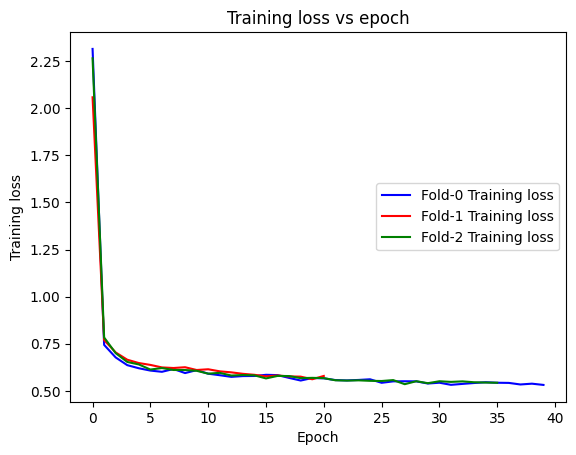

In [ ]:
with open('train_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training loss")

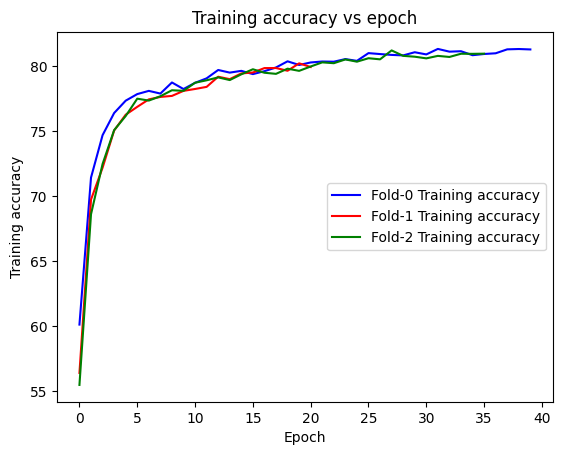

In [ ]:
with open('train_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training accuracy")

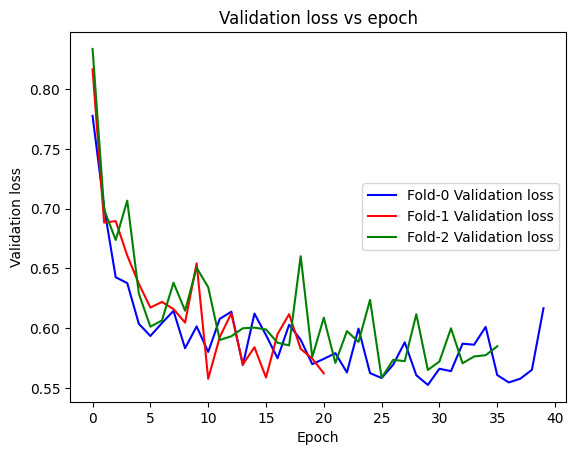

In [ ]:
with open('valid_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation loss")

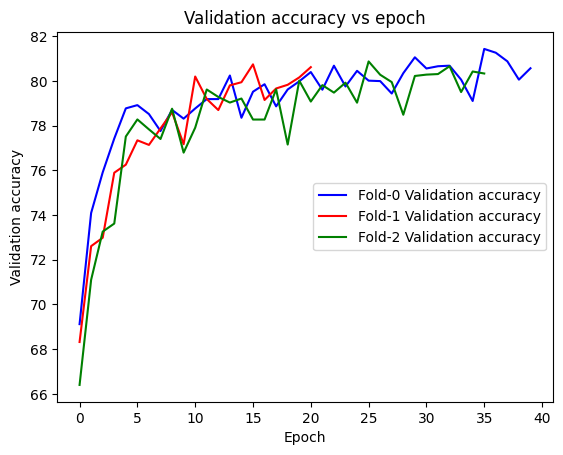

In [ ]:
with open('valid_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation accuracy")

### Testing the model on unseen data

In [ ]:
test_results = test_step(model, test_dataset, ann_params)

Accuracy for fold 0: 82.970
--------------------------------
Accuracy for fold 1: 82.435
--------------------------------
Accuracy for fold 2: 82.400
--------------------------------
Fold 0: 82.97 %
Fold 1: 82.435 %
Fold 2: 82.39999999999999 %
Mean accuracy: 82.602 with s.d:0.261


## CNN

### Model building

In [9]:
class Simple_CNN(nn.Module):

    def __init__(self):
        super(Simple_CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=512)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
model = Simple_CNN()
print(model)

Simple_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### Hyper-parameter setting

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
momentum = 0.9
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
k_folds = 3
#epochs = 50
epochs = 1
batch_size = 64
patience = 10

cnn_params = Params(criterion, learning_rate, momentum, optimizer, k_folds, epochs, batch_size, patience, device)

### Training and evaluating the model using k-fold

In [ ]:
train_results = train_val_step(model, train_dataset, cnn_params)

FOLD 0
----------Epoch 1----------
Epoch 1, Train loss: 0.580, Train accuracy: 78.418
Epoch 1, Val loss: 0.465, Val accuracy: 82.805
----------Epoch 2----------
Epoch 2, Train loss: 0.418, Train accuracy: 84.668
Epoch 2, Val loss: 0.411, Val accuracy: 85.315
----------Epoch 3----------
Epoch 3, Train loss: 0.373, Train accuracy: 86.475
Epoch 3, Val loss: 0.358, Val accuracy: 87.025
----------Epoch 4----------
Epoch 4, Train loss: 0.345, Train accuracy: 87.585
Epoch 4, Val loss: 0.338, Val accuracy: 87.810
----------Epoch 5----------
Epoch 5, Train loss: 0.322, Train accuracy: 88.362
Epoch 5, Val loss: 0.323, Val accuracy: 88.120
----------Epoch 6----------
Epoch 6, Train loss: 0.304, Train accuracy: 88.737
Epoch 6, Val loss: 0.312, Val accuracy: 88.770
----------Epoch 7----------
Epoch 7, Train loss: 0.292, Train accuracy: 89.310
Epoch 7, Val loss: 0.300, Val accuracy: 89.030
----------Epoch 8----------
Epoch 8, Train loss: 0.283, Train accuracy: 89.632
Epoch 8, Val loss: 0.298, Val ac

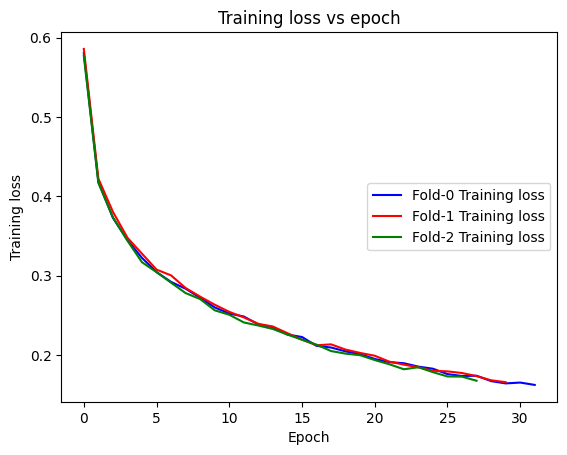

In [ ]:
with open('train_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training loss")

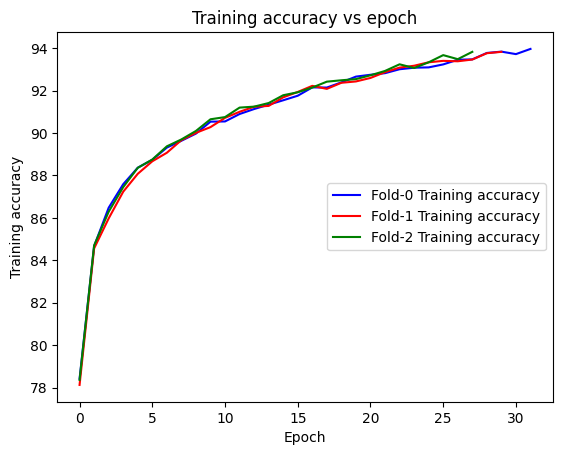

In [ ]:
with open('train_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training accuracy")

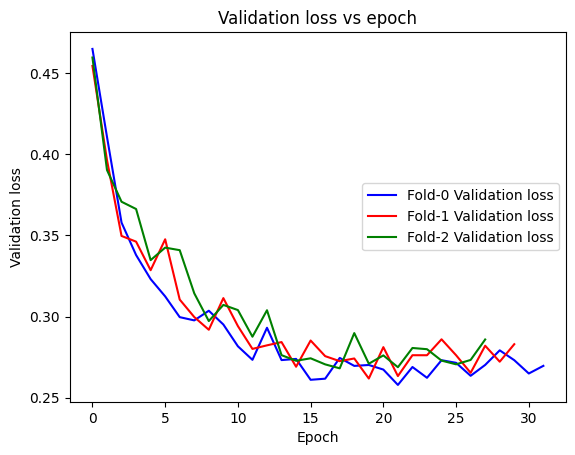

In [ ]:
with open('valid_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation loss")

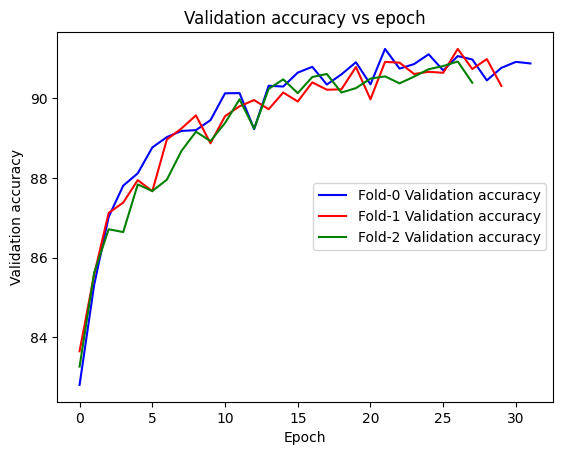

In [ ]:
with open('valid_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation accuracy")

### Testing the model on unseen data

In [ ]:
test_results = test_step(model, test_dataset, cnn_params)

Accuracy for fold 0: 91.470
--------------------------------
Accuracy for fold 1: 91.170
--------------------------------
Accuracy for fold 2: 91.350
--------------------------------
Fold 0: 91.47 %
Fold 1: 91.17 %
Fold 2: 91.35 %
Mean accuracy: 91.330 with s.d:0.123


After comparing the accuracy of ML models, ANN and CNN, we selected CNN as the best model for our experiment and proceeded towards hyper-parameter tuning of the CNN model.

## Hyper-parameter tuning of the CNN model - best model so far
### Learning rate and optimizer are selected to be tuned
*   Learning rate grid: [0.01, 0.001, 0.0001]
*   Optimizer: [Adam, SGD]

### HP 1: Learning rate = 0.01 and optimizer = Adam

#### Model building

In [ ]:
model = Simple_CNN()
print(model)

Simple_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


#### Hyper-parameter setting

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
momentum = 0.9
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
k_folds = 3
#epochs = 50
epochs = 1
batch_size = 64
patience = 10

cnn_params = Params(criterion, learning_rate, momentum, optimizer, k_folds, epochs, batch_size, patience, device)

#### Training and evaluating the model using k-fold

In [ ]:
train_results = train_val_step(model, train_dataset, cnn_params)

FOLD 0
----------Epoch 1----------
Epoch 1, Train loss: 0.877, Train accuracy: 68.843
Epoch 1, Val loss: 0.623, Val accuracy: 76.480
----------Epoch 2----------
Epoch 2, Train loss: 0.581, Train accuracy: 78.263
Epoch 2, Val loss: 0.548, Val accuracy: 79.790
----------Epoch 3----------
Epoch 3, Train loss: 0.519, Train accuracy: 81.138
Epoch 3, Val loss: 0.488, Val accuracy: 81.995
----------Epoch 4----------
Epoch 4, Train loss: 0.481, Train accuracy: 82.460
Epoch 4, Val loss: 0.465, Val accuracy: 83.475
----------Epoch 5----------
Epoch 5, Train loss: 0.466, Train accuracy: 83.263
Epoch 5, Val loss: 0.449, Val accuracy: 83.855
----------Epoch 6----------
Epoch 6, Train loss: 0.451, Train accuracy: 83.525
Epoch 6, Val loss: 0.474, Val accuracy: 82.780
----------Epoch 7----------
Epoch 7, Train loss: 0.438, Train accuracy: 84.180
Epoch 7, Val loss: 0.426, Val accuracy: 84.200
----------Epoch 8----------
Epoch 8, Train loss: 0.438, Train accuracy: 84.138
Epoch 8, Val loss: 0.436, Val ac

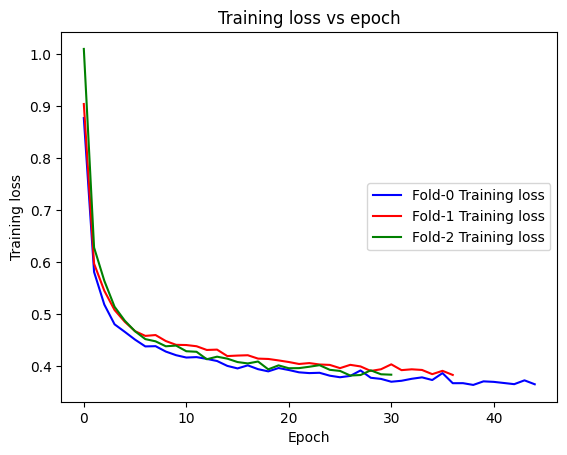

In [ ]:
with open('train_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training loss")

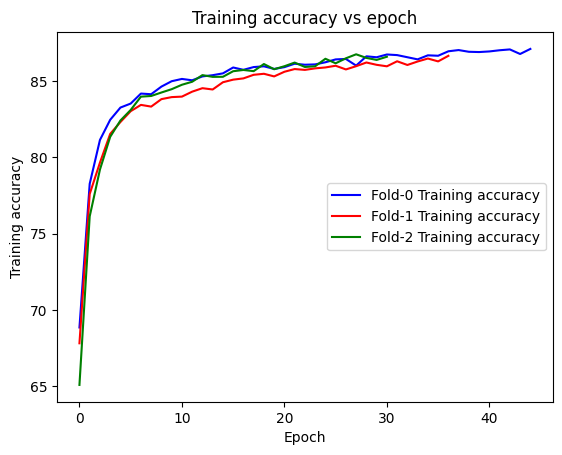

In [ ]:
with open('train_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training accuracy")

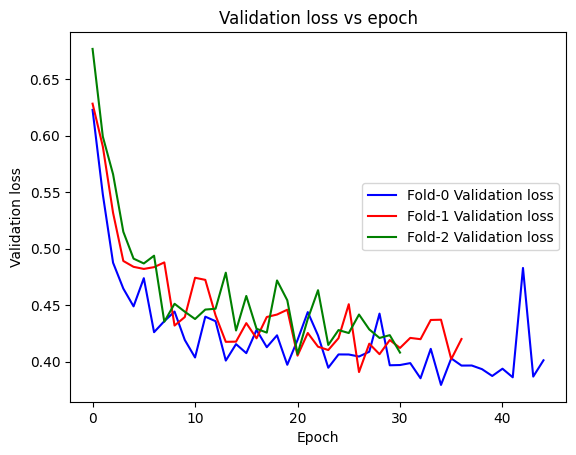

In [ ]:
with open('valid_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation loss")

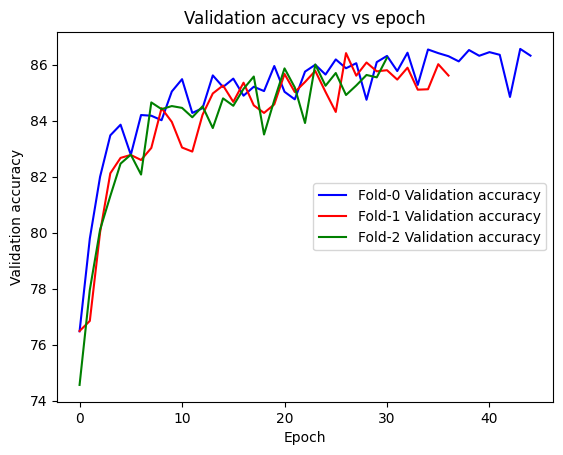

In [ ]:
with open('valid_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation accuracy")

#### Testing the model on unseen data

In [ ]:
test_results = test_step(model, test_dataset, cnn_params)

Accuracy for fold 0: 87.980
--------------------------------
Accuracy for fold 1: 87.195
--------------------------------
Accuracy for fold 2: 87.447
--------------------------------
Fold 0: 87.98 %
Fold 1: 87.195 %
Fold 2: 87.44666666666666 %
Mean accuracy: 87.541 with s.d:0.327


### HP 2: Learning rate = 0.001 and optimizer = Adam

*   This experiment was performed above and same results are taken from that section

### HP 3: Learning rate = 0.0001 and optimizer = Adam

#### Model building

In [ ]:
model = Simple_CNN()
print(model)

Simple_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


#### Hyper-parameter setting

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
momentum = 0.9
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
k_folds = 3
#epochs = 50
epochs = 1
batch_size = 64
patience = 10

cnn_params = Params(criterion, learning_rate, momentum, optimizer, k_folds, epochs, batch_size, patience, device)

#### Training and evaluating the model using k-fold

In [ ]:
train_results = train_val_step(model, train_dataset, cnn_params)

FOLD 0
----------Epoch 1----------
Epoch 1, Train loss: 0.726, Train accuracy: 74.215
Epoch 1, Val loss: 0.505, Val accuracy: 81.775
----------Epoch 2----------
Epoch 2, Train loss: 0.484, Train accuracy: 82.200
Epoch 2, Val loss: 0.448, Val accuracy: 83.650
----------Epoch 3----------
Epoch 3, Train loss: 0.431, Train accuracy: 84.302
Epoch 3, Val loss: 0.414, Val accuracy: 84.745
----------Epoch 4----------
Epoch 4, Train loss: 0.397, Train accuracy: 85.418
Epoch 4, Val loss: 0.395, Val accuracy: 85.740
----------Epoch 5----------
Epoch 5, Train loss: 0.374, Train accuracy: 86.368
Epoch 5, Val loss: 0.378, Val accuracy: 86.110
----------Epoch 6----------
Epoch 6, Train loss: 0.357, Train accuracy: 86.915
Epoch 6, Val loss: 0.348, Val accuracy: 87.350
----------Epoch 7----------
Epoch 7, Train loss: 0.341, Train accuracy: 87.543
Epoch 7, Val loss: 0.344, Val accuracy: 87.685
----------Epoch 8----------
Epoch 8, Train loss: 0.329, Train accuracy: 87.862
Epoch 8, Val loss: 0.343, Val ac

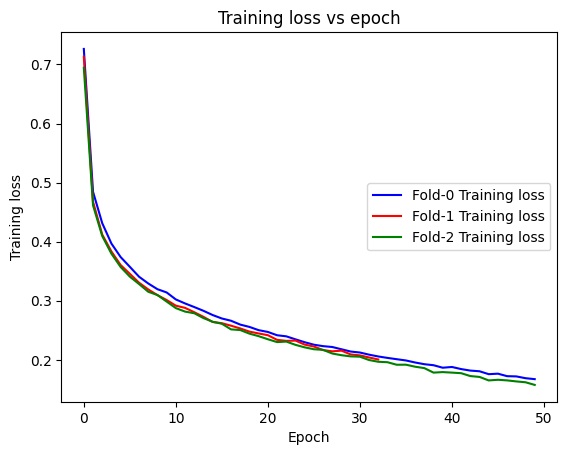

In [ ]:
with open('train_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training loss")

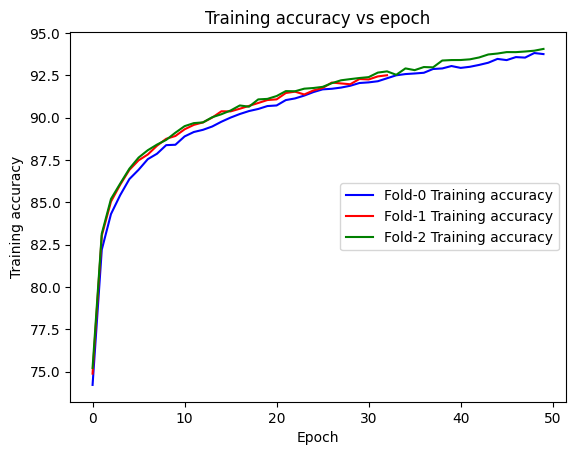

In [ ]:
with open('train_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training accuracy")

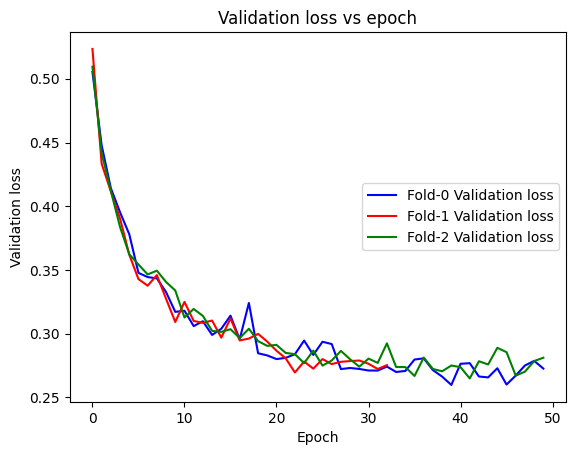

In [ ]:
with open('valid_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation loss")

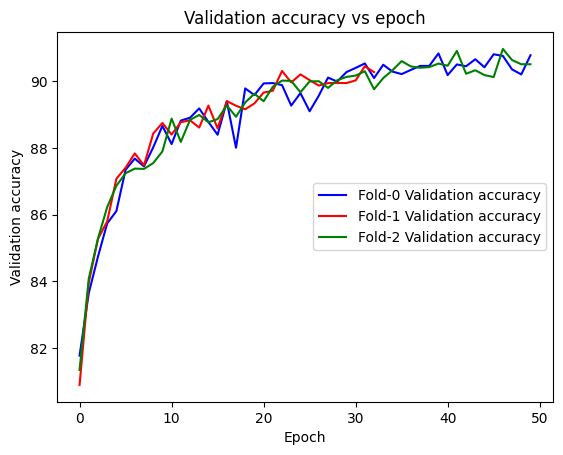

In [ ]:
with open('valid_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation accuracy")

#### Testing the model on unseen data

In [ ]:
test_results = test_step(model, test_dataset, cnn_params)

Accuracy for fold 0: 90.810
--------------------------------
Accuracy for fold 1: 90.853
--------------------------------
Accuracy for fold 2: 91.013
--------------------------------
Fold 0: 90.81 %
Fold 1: 90.85333333333332 %
Fold 2: 91.01285714285714 %
Mean accuracy: 90.892 with s.d:0.087


### HP 4: Learning rate = 0.01 and optimizer = SGD

#### Model building

In [ ]:
model = Simple_CNN()
print(model)

Simple_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


#### Hyper-parameter setting

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
k_folds = 3
#epochs = 50
epochs = 1
batch_size = 64
patience = 10

cnn_params = Params(criterion, learning_rate, momentum, optimizer, k_folds, epochs, batch_size, patience, device)

#### Training and evaluating the model using k-fold

In [ ]:
train_results = train_val_step(model, train_dataset, cnn_params)

FOLD 0
----------Epoch 1----------
Epoch 1, Train loss: 0.658, Train accuracy: 75.888
Epoch 1, Val loss: 0.530, Val accuracy: 80.400
----------Epoch 2----------
Epoch 2, Train loss: 0.451, Train accuracy: 83.233
Epoch 2, Val loss: 0.415, Val accuracy: 84.580
----------Epoch 3----------
Epoch 3, Train loss: 0.402, Train accuracy: 85.188
Epoch 3, Val loss: 0.371, Val accuracy: 86.890
----------Epoch 4----------
Epoch 4, Train loss: 0.364, Train accuracy: 86.650
Epoch 4, Val loss: 0.350, Val accuracy: 87.120
----------Epoch 5----------
Epoch 5, Train loss: 0.342, Train accuracy: 87.335
Epoch 5, Val loss: 0.324, Val accuracy: 88.205
----------Epoch 6----------
Epoch 6, Train loss: 0.322, Train accuracy: 88.103
Epoch 6, Val loss: 0.314, Val accuracy: 88.425
----------Epoch 7----------
Epoch 7, Train loss: 0.309, Train accuracy: 88.647
Epoch 7, Val loss: 0.319, Val accuracy: 88.325
----------Epoch 8----------
Epoch 8, Train loss: 0.299, Train accuracy: 88.775
Epoch 8, Val loss: 0.315, Val ac

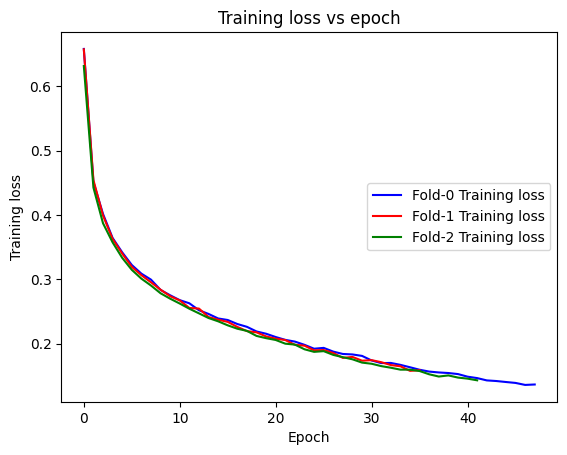

In [ ]:
with open('train_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training loss")

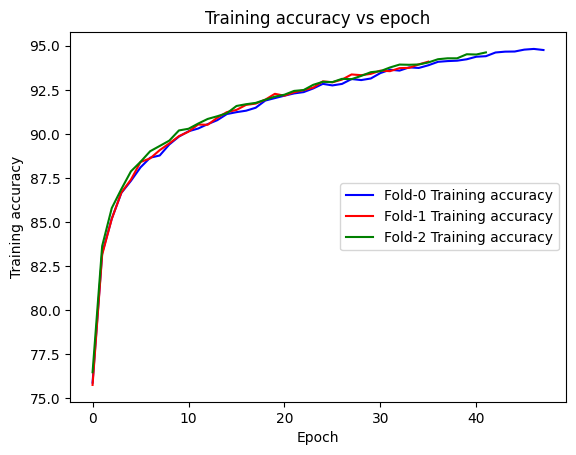

In [ ]:
with open('train_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training accuracy")

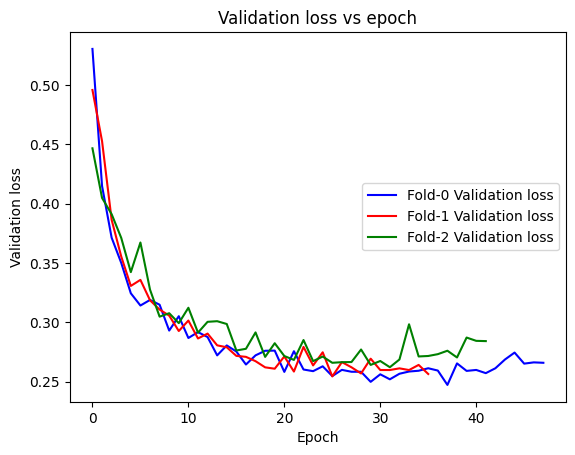

In [ ]:
with open('valid_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation loss")

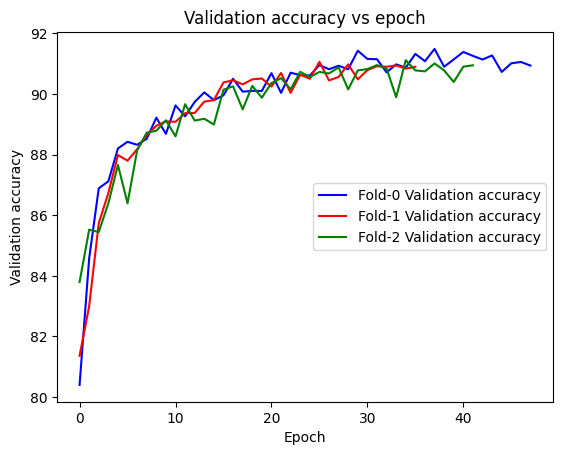

In [ ]:
with open('valid_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation accuracy")

#### Testing the model on unseen data

In [ ]:
test_results = test_step(model, test_dataset, cnn_params)

Accuracy for fold 0: 91.820
--------------------------------
Accuracy for fold 1: 91.800
--------------------------------
Accuracy for fold 2: 91.960
--------------------------------
Fold 0: 91.82000000000001 %
Fold 1: 91.8 %
Fold 2: 91.96 %
Mean accuracy: 91.860 with s.d:0.071


### HP 5: Learning rate = 0.001 and optimizer = SGD

#### Model building

In [ ]:
model = Simple_CNN()
print(model)

Simple_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


#### Hyper-parameter setting

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
k_folds = 3
#epochs = 50
epochs = 1
batch_size = 64
patience = 10

cnn_params = Params(criterion, learning_rate, momentum, optimizer, k_folds, epochs, batch_size, patience, device)

#### Training and evaluating the model using k-fold

In [ ]:
train_results = train_val_step(model, train_dataset, cnn_params)

FOLD 0
----------Epoch 1----------
Epoch 1, Train loss: 0.993, Train accuracy: 66.630
Epoch 1, Val loss: 0.632, Val accuracy: 76.240
----------Epoch 2----------
Epoch 2, Train loss: 0.579, Train accuracy: 78.275
Epoch 2, Val loss: 0.538, Val accuracy: 80.010
----------Epoch 3----------
Epoch 3, Train loss: 0.501, Train accuracy: 81.525
Epoch 3, Val loss: 0.478, Val accuracy: 82.240
----------Epoch 4----------
Epoch 4, Train loss: 0.455, Train accuracy: 83.625
Epoch 4, Val loss: 0.429, Val accuracy: 84.440
----------Epoch 5----------
Epoch 5, Train loss: 0.426, Train accuracy: 84.453
Epoch 5, Val loss: 0.403, Val accuracy: 85.665
----------Epoch 6----------
Epoch 6, Train loss: 0.400, Train accuracy: 85.522
Epoch 6, Val loss: 0.426, Val accuracy: 84.820
----------Epoch 7----------
Epoch 7, Train loss: 0.386, Train accuracy: 86.142
Epoch 7, Val loss: 0.374, Val accuracy: 86.680
----------Epoch 8----------
Epoch 8, Train loss: 0.373, Train accuracy: 86.532
Epoch 8, Val loss: 0.372, Val ac

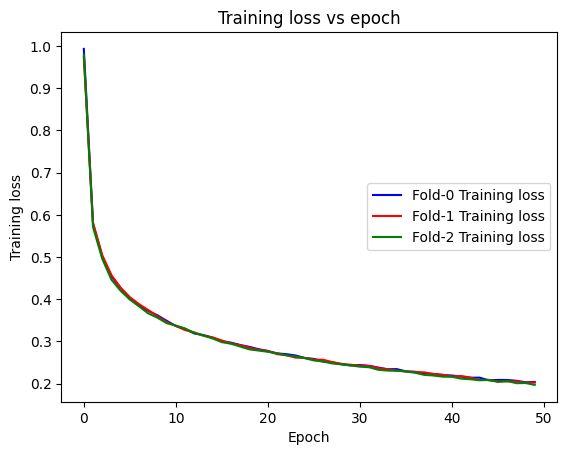

In [ ]:
with open('train_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training loss")

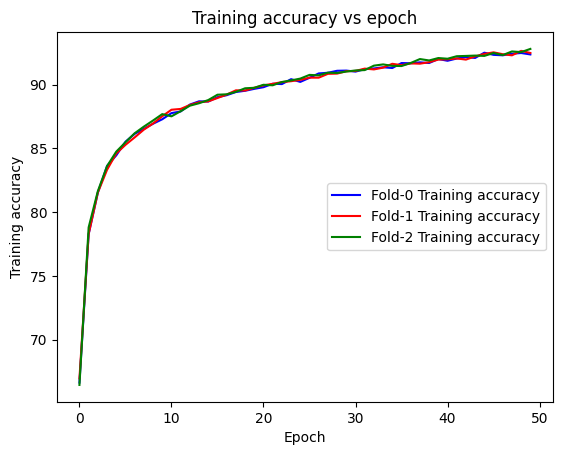

In [ ]:
with open('train_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training accuracy")

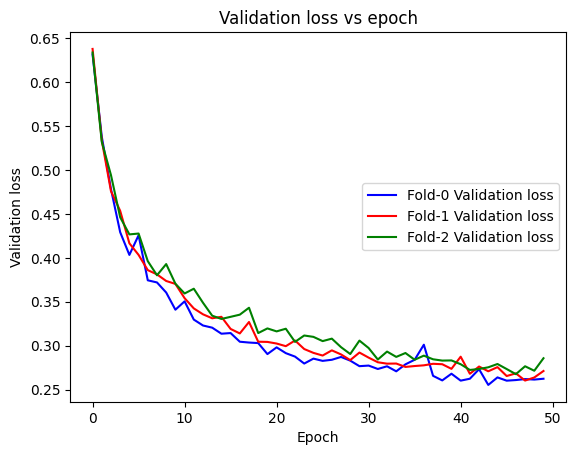

In [ ]:
with open('valid_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation loss")

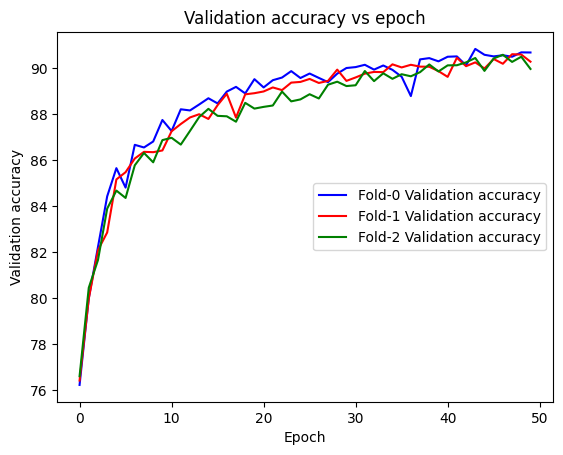

In [ ]:
with open('valid_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation accuracy")

#### Testing the model on unseen data

In [ ]:
test_results = test_step(model, test_dataset, cnn_params)

Accuracy for fold 0: 91.090
--------------------------------
Accuracy for fold 1: 91.135
--------------------------------
Accuracy for fold 2: 91.117
--------------------------------
Fold 0: 91.09 %
Fold 1: 91.135 %
Fold 2: 91.11666666666667 %
Mean accuracy: 91.114 with s.d:0.018


### HP 6: Learning rate = 0.0001 and optimizer = SGD

#### Model building

In [ ]:
model = Simple_CNN()
print(model)

Simple_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


#### Hyper-parameter setting

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
k_folds = 3
#epochs = 50
epochs = 1
batch_size = 64
patience = 10

cnn_params = Params(criterion, learning_rate, momentum, optimizer, k_folds, epochs, batch_size, patience, device)

#### Training and evaluating the model using k-fold

In [ ]:
train_results = train_val_step(model, train_dataset, cnn_params)

FOLD 0
----------Epoch 1----------
Epoch 1, Train loss: 2.007, Train accuracy: 36.108
Epoch 1, Val loss: 1.629, Val accuracy: 49.990
----------Epoch 2----------
Epoch 2, Train loss: 1.337, Train accuracy: 59.455
Epoch 2, Val loss: 1.127, Val accuracy: 65.230
----------Epoch 3----------
Epoch 3, Train loss: 1.020, Train accuracy: 67.472
Epoch 3, Val loss: 0.929, Val accuracy: 70.020
----------Epoch 4----------
Epoch 4, Train loss: 0.874, Train accuracy: 70.620
Epoch 4, Val loss: 0.820, Val accuracy: 72.445
----------Epoch 5----------
Epoch 5, Train loss: 0.789, Train accuracy: 72.460
Epoch 5, Val loss: 0.751, Val accuracy: 74.095
----------Epoch 6----------
Epoch 6, Train loss: 0.732, Train accuracy: 73.740
Epoch 6, Val loss: 0.707, Val accuracy: 74.905
----------Epoch 7----------
Epoch 7, Train loss: 0.691, Train accuracy: 75.183
Epoch 7, Val loss: 0.667, Val accuracy: 75.690
----------Epoch 8----------
Epoch 8, Train loss: 0.664, Train accuracy: 75.778
Epoch 8, Val loss: 0.645, Val ac

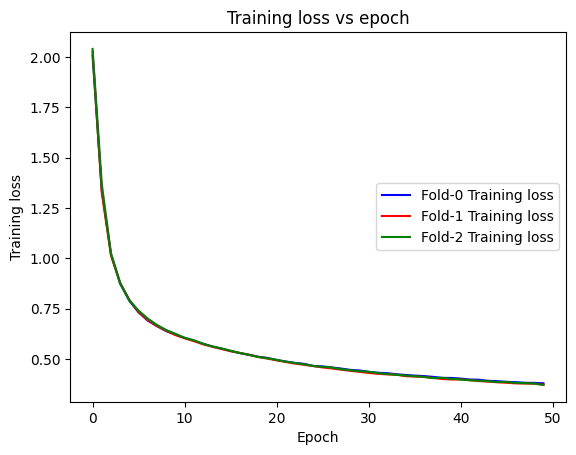

In [ ]:
with open('train_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training loss")

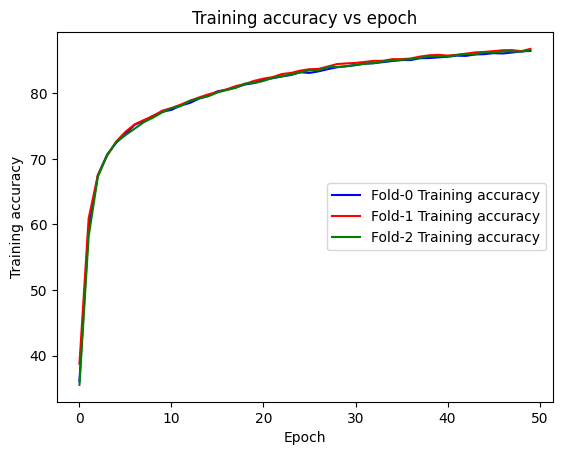

In [ ]:
with open('train_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Training accuracy")

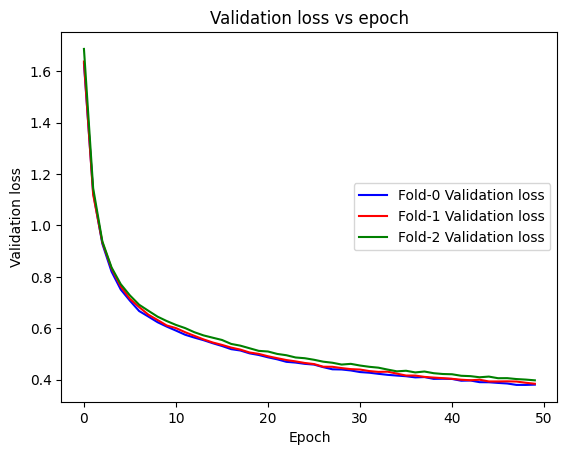

In [ ]:
with open('valid_loss.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation loss")

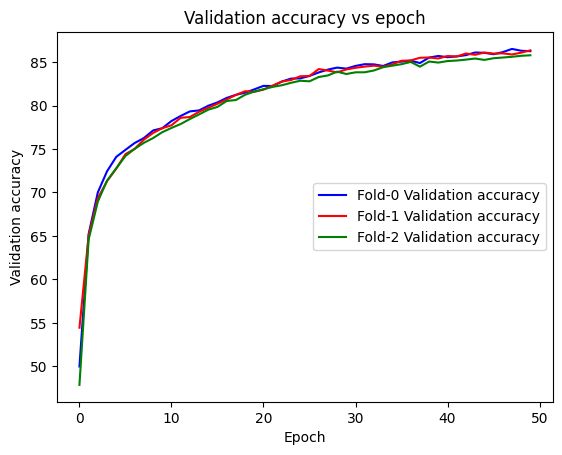

In [ ]:
with open('valid_accuracy.pkl', 'rb') as fp:
    train_loss = pickle.load(fp)

plot_loss(train_loss, "Validation accuracy")

#### Testing the model on unseen data

In [ ]:
test_results = test_step(model, test_dataset, cnn_params)

Accuracy for fold 0: 86.790
--------------------------------
Accuracy for fold 1: 87.050
--------------------------------
Accuracy for fold 2: 87.100
--------------------------------
Fold 0: 86.79 %
Fold 1: 87.05000000000001 %
Fold 2: 87.1 %
Mean accuracy: 86.980 with s.d:0.136


## Loading the best model for further analysis
*   CNN with learning rate = 0.01 and SGD optimizer gave the best results.
*   We will generate evaluation metrics and qualitative analysis on test dataset with this model.
*   All the previous models were downloaded and saved seperately.
*   To conduct further research we will load the saved model for HP 4.

In [41]:
model = Simple_CNN()
test_loader = DataLoader(test_dataset, batch_size=1)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
k_folds = 3
#epochs = 50
epochs = 1
batch_size = 64
patience = 10

cnn_params = Params(criterion, learning_rate, momentum, optimizer, k_folds, epochs, batch_size, patience, device)

pred_final = {}

for fold in range(cnn_params.k_folds):
    model.to(device)
    model_save_path = './model-fold-' + str(fold) + '.pth'
    model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
    model.eval()

    predictions = []
    groundtruth = []

    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader, 0):

            image, label = image.to(device), label.to(device)

            output = model(image)

            predictions += torch.max(output, 1)[1]
            groundtruth += label.detach()


    pred_final[fold] = {}

    pred_final[fold]['pred'] = predictions
    pred_final[fold]['gt'] = groundtruth
    pred_final[fold]['classification_report'] = classification_report(groundtruth, predictions)
    pred_final[fold]['confusion_matrix'] = confusion_matrix(groundtruth, predictions)

    print('\n---------------FOLD: {} -----------------\n'.format(fold))
    print(pred_final[fold]['classification_report'])


---------------FOLD: 0 -----------------

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1000
           1       0.99      0.98      0.98      1000
           2       0.89      0.87      0.88      1000
           3       0.93      0.90      0.92      1000
           4       0.85      0.92      0.88      1000
           5       0.99      0.98      0.98      1000
           6       0.78      0.72      0.75      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[891   1  17  11   3   2  70   0   5   0]
 [  0 981   0  12   2   0   3   0   2   0]
 [ 20   0 868   6  58   0  47   0   1   0]
 [ 24  10  13 899  23   0  31   0   0   0]
 [  0   0  12  19 917   0 

In [17]:
class_labels = []
for k,v in labels_map_dict.items():
    class_labels.append(v)

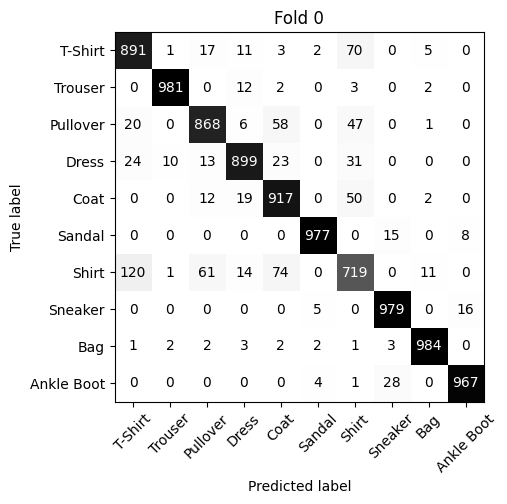

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix = pred_final[0]['confusion_matrix'], display_labels=class_labels)
disp.plot(cmap="Greys", xticks_rotation=45, colorbar=False)
plt.title("Fold 0")
plt.show();

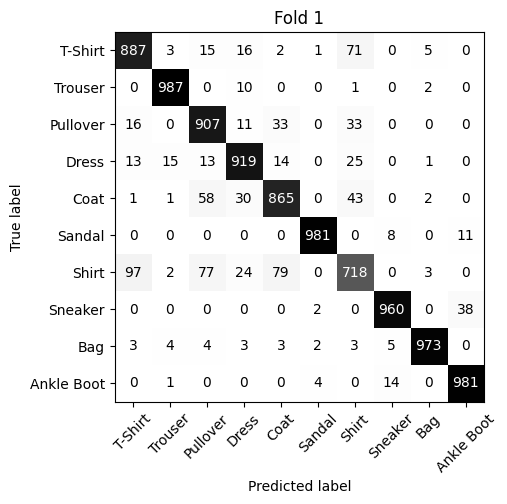

In [64]:
disp = ConfusionMatrixDisplay(confusion_matrix = pred_final[1]['confusion_matrix'], display_labels=class_labels)
disp.plot(cmap="Greys", xticks_rotation=45, colorbar=False)
plt.title("Fold 1")
plt.show();

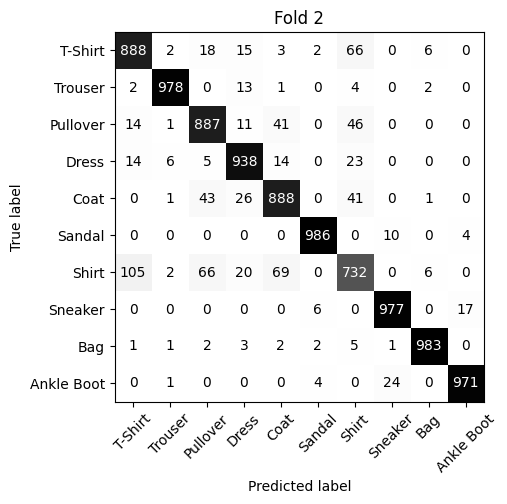

In [65]:
disp = ConfusionMatrixDisplay(confusion_matrix = pred_final[2]['confusion_matrix'], display_labels=class_labels)
disp.plot(cmap="Greys", xticks_rotation=45, colorbar=False)
plt.title("Fold 2")
plt.show();